Begin with standard imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import openflexure_microscope_client
import json
import pprint

Connect to your microscope using the IP address of the microscope

In [5]:
microscope = openflexure_microscope_client.MicroscopeClient("169.254.124.226")

A few useful functions to collect and interpret the data

In [6]:
def turningpoints(lst):
    dx = np.diff(lst)
    return (dx[1:] * dx[:-1] < 0)

def looping_autofocus(microscope):
    repeat = True
    dz=2000
    while repeat:
        data = microscope.autofocus()
        heights, sizes = unpack_autofocus(data)
        if microscope.position['z'] - min(heights) < dz / 10 or max(heights) - microscope.position['z'] < dz / 10:
            pass
        else:
            repeat = False
            
def unpack_autofocus(scan_data):
    """Extract z, sharpness data from a move_and_measure call
    
    Data will start at `start_index`, i.e. `start_index` points are dropped
    from the beginning of the array.
    """
    jpeg_times = scan_data['jpeg_times']
    jpeg_sizes = scan_data['jpeg_sizes']
    jpeg_sizes_MB = [x / 10**3 for x in jpeg_sizes]
    stage_times = scan_data['stage_times']
    stage_positions = scan_data['stage_positions']
    stage_height = [pos[2] for pos in stage_positions]

    jpeg_heights = np.interp(jpeg_times,stage_times,stage_height)

    turning = np.where(turningpoints(jpeg_heights))[0]+1

    return jpeg_heights[turning[0]:turning[1]], jpeg_sizes_MB[turning[0]:turning[1]]

## Place your sample under the microscope, well centred and focused

Performs the movements necessary to map the z motion and find the rough centre. Max steps limits the number of positions in a direction to try (should not be less than 4) and dx sets the distance between locations to be tested. If you make this too large, it'll be slow and may reach the edge of the range of motion. Too small and the fit will be less reliable

This code will scan along a line in x, moving until the peak height is crossed. It'll then do the same in y, allowing an estimation of the centre and type of motion to be stored.

In [7]:
max_steps = 19
dx = 5000

focused_pos = []
centre = list(microscope.position.values())

focused_pos = [[],[]]

looping_autofocus(microscope)

for direction in [0, 1]:
    focused_pos[direction] = [list(microscope.position.values())]
    moves = +1
    dx = dx
    microscope.move(centre)
    for i in range(max_steps):
        if moves > 0:
            starting_point = np.max(np.array(focused_pos[direction])[:,direction])
        else:
            starting_point = np.min(np.array(focused_pos[direction])[:,direction])
        
        destination = centre
        destination[direction] = starting_point + moves * dx

        microscope.move(destination)
        position = list(microscope.position.values())

        x_diff = position[0]-centre[0]
        y_diff = position[1]-centre[1]
        r = np.sqrt(x_diff**2+y_diff**2)
        z_diff = int(-1.3 * 10**-6 * r**2 + 3.5 * 10**-2 * r)

        microscope.move_rel([0,0,z_diff])

        looping_autofocus(microscope)
        focused_pos[direction].append(list(microscope.position.values()))

        if microscope.position['z'] > focused_pos[direction][-2][2]:
            moves *= -1

        print(focused_pos[direction])
        print(np.argmin(np.array(focused_pos[direction])[:,2]), np.argmin(np.array(focused_pos[direction])[:,direction]), np.argmin(np.array(focused_pos[direction])[:,direction]))

        if len(focused_pos[direction]) > 2:
            if np.argmin(np.array(focused_pos[direction])[:,2]) != np.argmin(np.array(focused_pos[direction])[:,direction]) and np.argmin(np.array(focused_pos[direction])[:,direction]) != np.argmin(np.array(focused_pos[direction])[:,2]):
                print(f'Breaking because the lowest point is at {np.argmin(np.array(focused_pos[direction])[:,2])} in the list')
                break
    
    centre[0] = focused_pos[0][np.argmin(np.array(focused_pos[0])[:,2])][0]

print(focused_pos)

[[42029, -283, 21841], [47029, -283, 21955]]
0 0 0
[[42029, -283, 21841], [47029, -283, 21955], [37029, -283, 21725]]
2 2 2
[[42029, -283, 21841], [47029, -283, 21955], [37029, -283, 21725], [32029, -283, 21740]]
2 3 3
Breaking because the lowest point is at 2 in the list
[[32029, -283, 21740], [37029, 4717, 21922]]
0 0 0
[[32029, -283, 21740], [37029, 4717, 21922], [37029, -5283, 21672]]
2 2 2
[[32029, -283, 21740], [37029, 4717, 21922], [37029, -5283, 21672], [37029, -10283, 21625]]
3 3 3
[[32029, -283, 21740], [37029, 4717, 21922], [37029, -5283, 21672], [37029, -10283, 21625], [37029, -15283, 21674]]
3 4 4
Breaking because the lowest point is at 3 in the list
[[[42029, -283, 21841], [47029, -283, 21955], [37029, -283, 21725], [32029, -283, 21740]], [[32029, -283, 21740], [37029, 4717, 21922], [37029, -5283, 21672], [37029, -10283, 21625], [37029, -15283, 21674]]]


Store the positions as a json file, and slice them ready for plotting

In [8]:
with open('heightmap_full.json', 'w') as f:
    json.dump(focused_pos, f)

to_plot = focused_pos.copy()
to_plot = [[e for sl in to_plot for e in sl]]

print(to_plot[0])

to_plot_x = np.array([loc[0] for loc in to_plot[0]])
to_plot_y = np.array([loc[1] for loc in to_plot[0]])
to_plot_z = np.array([loc[2] for loc in to_plot[0]])

to_plot_all = np.array(to_plot[0])

[[42029, -283, 21841], [47029, -283, 21955], [37029, -283, 21725], [32029, -283, 21740], [32029, -283, 21740], [37029, 4717, 21922], [37029, -5283, 21672], [37029, -10283, 21625], [37029, -15283, 21674]]


Plot the trends in x and y. Should see a peak in each

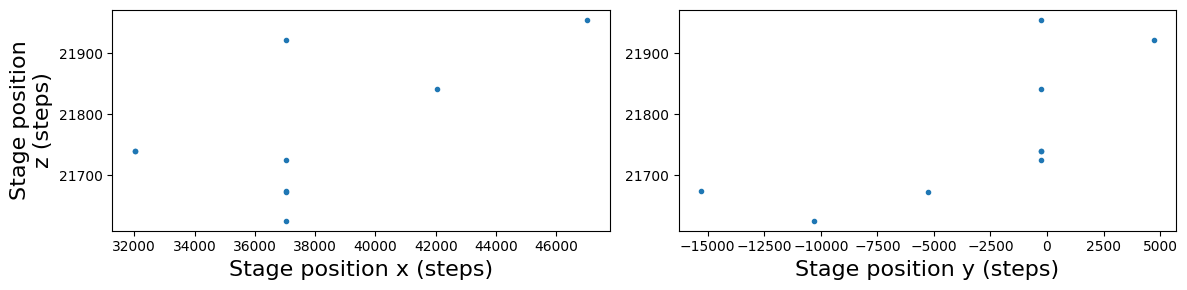

In [9]:
import plotly

cols = 2
rows = 1


fig = plt.figure(figsize=(12, 3))
import matplotlib.gridspec as gridspec
G = gridspec.GridSpec(rows, cols)


ax2 = fig.add_subplot(G[rows-1,0])
ax2.plot(to_plot_x, to_plot_z,'.')

ax3 = fig.add_subplot(G[rows-1,1])
ax3.plot(to_plot_y, to_plot_z,'.')
ax2.set_xlabel('Stage position x (steps)', fontsize = 16)
ax2.set_ylabel('Stage position\nz (steps)', fontsize = 16)
ax3.set_xlabel('Stage position y (steps)', fontsize = 16)
plt.tight_layout()
plt.show()

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=to_plot_x, y=to_plot_y, z=to_plot_z,
                                   mode='markers')])

fig.show()

Fit a quadratic to the z movement against both x and y seperately

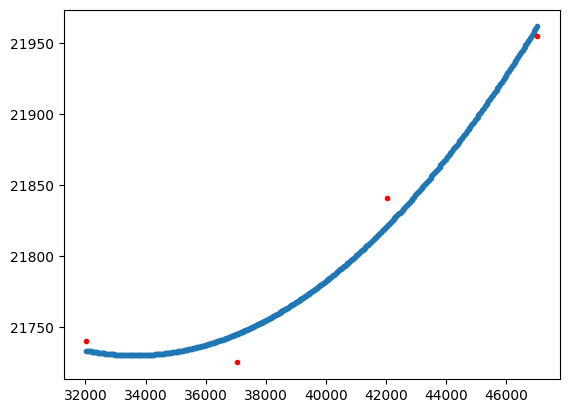

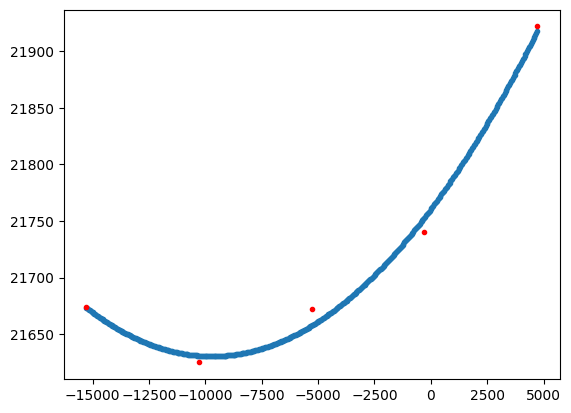

{'x': 33622, 'y': -9711, 'z': 21922}

In [11]:
x_coords = np.array(focused_pos[0])
y_coords = np.array(focused_pos[1])

quad_params = []

x = x_coords[:, 0]
x_new = np.linspace(min(x), max(x), 500)
quad_params.append(np.polyfit(x, x_coords[:, 2], 2))
f = np.poly1d(quad_params[-1])
y_new = f(x_new)

plt.plot(x_new, y_new, '.')
plt.plot(x, x_coords[:, 2], '.', color = 'red')
plt.show()
x_centre = int(x_new[np.argmin(y_new)])

x = y_coords[:, 1]
x_new = np.linspace(min(x), max(x), 500)
quad_params.append(np.polyfit(x, y_coords[:, 2], 2))
f = np.poly1d(quad_params[-1])
y_new = f(x_new)

plt.plot(x_new, y_new, '.')
plt.plot(x, y_coords[:, 2], '.', color = 'red')
plt.show()
y_centre = int(x_new[np.argmin(y_new)])

z_max = np.max(np.array(focused_pos[1])[:,2])

microscope.move([x_centre, y_centre, z_max])

Update the microscope settings folder with these estimations

In [ ]:
import requests

def put_json(self, path, payload = {}):
    if not path.startswith("http"):
        path = self.base_uri + path
    r = requests.put(path, json = payload)
    r.raise_for_status()
    r = r.json()
    return r

def pull_settings(self):
    """Download the current microscope settings as a JSON"""
    return self.get_json("/instrument/settings")

def post_settings(self, params):
    """Update the microscope settings file with params"""
    return put_json(microscope, "/instrument/settings", params)

In [ ]:
settings = pull_settings(microscope)

settings['extensions']['org.openflexure.self_centred'] = {
    'centre' : {
    'x' : int(x_centre),
    'y' : int(y_centre),
    'z' : int(z_max) 
    },
    'x_fit' :{
    'a' : quad_params[0][0],
    'b' : quad_params[0][1],
    'c' : quad_params[0][2],
    },
    'y_fit' :{
    'a' : quad_params[1][0],
    'b' : quad_params[1][1],
    'c' : quad_params[1][2],
    }
}

post_settings(microscope, settings)

pprint.pprint(settings['extensions']['org.openflexure.self_centred'])

Plot the x vs z fit as a sanity check

In [ ]:
centre = [settings['extensions']['org.openflexure.self_centred']['centre']['x'], settings['extensions']['org.openflexure.self_centred']['centre']['y'], settings['extensions']['org.openflexure.self_centred']['centre']['z']] 
x_fit = [settings['extensions']['org.openflexure.self_centred']['x_fit']['a'], settings['extensions']['org.openflexure.self_centred']['x_fit']['b'], settings['extensions']['org.openflexure.self_centred']['x_fit']['c']]

x = np.linspace(-1000,10000,10000) + centre[0]

f = np.poly1d(np.array(x_fit))
z = f(x)

plt.plot(x, z)
plt.show()

In [ ]:
microscope.move([int(x_centre), int(y_centre), int(z_max)]) 